In [178]:
import pandas as pd
import zipfile
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
from scipy import stats
import matplotlib as mpl
pd.set_option('display.max_rows', 250)
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [179]:
# Load clustering results
cluster_nde75_ntotal50 = pd.read_csv('../../metadata/clustering_results.csv', index_col=0)
enrichment_df = pd.read_csv('./results/clustering_nde75ntotal50_enrichment.csv', index_col=0)
cluster_df = pd.read_csv('./results/clustering_condition_specificity.csv', index_col=0)
mask = cluster_df.cluster_gene_size>=4
cluster_df_filtered = cluster_df[mask].copy()

In [180]:
# Load HPA expression results
file_name = "../../metadata/rna_tissue_consensus.tsv.zip"
df_exp = pd.read_csv(file_name, sep='\t', compression='zip')
df_exp['log1p_nTPM'] = np.log1p(df_exp['nTPM'])
df_exp = df_exp[df_exp['Gene'].isin(cluster_nde75_ntotal50['target_contrast_corrected'].unique().tolist())].copy()

### First calculate the expression specificity index (tau) and tissue expression enrichment for selective genes

In [194]:
# Tissue expression enrichment fold change threshold
LFC_THRESHOLD = 2.5
# Threshold for large tau
TAU_THRESHOLD = 0.5

In [195]:
def calculate_tau(row):
    """
    Calculates Tau specificity index.
    Formula: Sum(1 - (xi / max_x)) / (N - 1)
    """
    if row.max() == 0:
        return 0.0
    
    x_hat = row / row.max()
    tau = (1 - x_hat).sum() / (len(row) - 1)
    return tau

def analyze_gene_set(gene_set_name, gene_names_list, final_df, tau_threshold=0.5):
    """
    Calculates the fraction of genes above a Tau threshold and the fraction
    enriched in each tissue for a given gene set.
    """
    # Filter the final_df for the genes in the set using the 'Gene name' level of the MultiIndex
    set_data = final_df[final_df.index.get_level_values('Gene').isin(gene_names_list)]

    N = len(set_data)
    
    # 1. Fraction of genes with Tau_Index > threshold
    tau_frac = (set_data['Tau_Index'] > tau_threshold).sum() / N
    
    result_dict = {'large_tau_fraction': tau_frac}

    # 2. Fraction of genes enriched in each tissue
    # Select columns ending with ' (Enriched)'
    enrichment_cols = [col for col in set_data.columns if col.endswith(' (Enriched)')]
    
    for col in enrichment_cols:
        # .sum() works on boolean columns (True=1, False=0). Divide by N to get fraction.
        enrichment_frac = set_data[col].sum() / N
        
        # Clean up column name for final output (e.g., 'adipose tissue (Enriched)' -> 'adipose tissue_Enrich_Fraction')
        clean_col = col.replace(' (Enriched)', '')
        result_dict[clean_col] = enrichment_frac
        
    return pd.Series(result_dict, name=gene_set_name)

In [196]:
# Pivot to get Genes x Tissues matrix using log1p_nTPM
tau_pivot = df_exp.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='log1p_nTPM', 
    fill_value=0
)

# Apply Tau calculation row-wise
tau_series = tau_pivot.apply(calculate_tau, axis=1)
tau_series.name = 'Tau_Index'

# Calculate Log2 Fold Change
median_ntpm = df_exp.groupby(['Gene', 'Gene name'])['nTPM'].transform('median')
df_exp['LFC'] = np.log2((df_exp['nTPM'] + 1e-6) / (median_ntpm + 1e-6))
df_exp['Enriched'] = df_exp['LFC'] > LFC_THRESHOLD
# Pivot
lfc_pivot = df_exp.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='LFC'
).add_suffix(' (LFC)')

enrich_pivot = df_exp.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='Enriched'
).add_suffix(' (Enriched)')
lfc_pivot = lfc_pivot.fillna(0)
enrich_pivot = enrich_pivot.fillna(False).astype(bool)
final_df = pd.concat([tau_series, lfc_pivot, enrich_pivot], axis=1)
final_df = final_df.reindex(sorted(final_df.columns), axis=1)

cols = ['Tau_Index'] + [c for c in final_df.columns if c != 'Tau_Index']
final_df = final_df[cols]

In [197]:
# Check fraction of genes that have large tau, and have tissue expression enrichment in each tissue
num_clusters = 111
gene_sets = {}
for cl in range(num_clusters):
    gene_ids = cluster_nde75_ntotal50[cluster_nde75_ntotal50.hdbscan==cl].target_contrast_corrected.unique().tolist()
    gene_sets[cl] = gene_ids

results = []

for cluster_id, gene_list in gene_sets.items():
    set_result = analyze_gene_set(cluster_id, gene_list, final_df, tau_threshold=TAU_THRESHOLD)
    results.append(set_result)

gene_set_analysis_df = pd.DataFrame(results)
#gene_set_analysis_df = gene_set_analysis_df.reset_index().rename(columns={'index': 'cluster'})

### Get clusters with gene set enrichment or without gene set enrichment (CORUM, STRINGDB, KEGG, REACTOME)

In [198]:
fdr_thres = 0.05
overlap_size_thres = 2
overlap_fraction_thres = 0.15

In [199]:
columns_to_keep = ['cluster_gene_size',
                   'overlap_fraction_corum',
                   'overlap_size_corum',
                   'fdr_corum',
                   'overlap_fraction_stringdb',
                   'overlap_size_stringdb',
                   'fdr_stringdb',
                   'overlap_fraction_kegg',
                   'overlap_size_kegg',
                   'fdr_kegg',
                   'overlap_fraction_reactome',
                   'overlap_size_reactome',
                   'fdr_reactome']
enrichment_df_filtered = enrichment_df.set_index('cluster').loc[cluster_df_filtered.index, columns_to_keep]

def add_enrichment_column(df):
    """
    Criteria for enrichment: 
    1. enrichment significance fdr < fdr_thres;
    2. overlap gene size > overlap_size_thres;
    3. overlap gene fraction > overlap_fraction_thres;
    for any database
    """
    suffixes = [col.replace('fdr_', '') for col in df.columns if col.startswith('fdr_')]
    df['enrichment'] = False
    for suffix in suffixes:
        fdr_col = f'fdr_{suffix}'
        size_col = f'overlap_size_{suffix}'
        frac_col = f'overlap_fraction_{suffix}'
        if size_col in df.columns and frac_col in df.columns:
            condition_met = (
                (df[fdr_col] < fdr_thres) & 
                (df[size_col] >= overlap_size_thres) & 
                (df[frac_col] > overlap_fraction_thres)
            )
            df['enrichment'] = df['enrichment'] | condition_met
    return df

enrichment_df_filtered = add_enrichment_column(enrichment_df_filtered)

### Plot the tissue expression enrichment results

In [200]:
tissue_spec_vs_enrichment = pd.merge(enrichment_df_filtered[['cluster_gene_size', 'enrichment']], gene_set_analysis_df, how='inner', left_index=True, right_index=True)
tissue_spec_vs_enrichment = tissue_spec_vs_enrichment.reset_index()
tissue_spec_vs_enrichment = tissue_spec_vs_enrichment.rename(columns={'index': 'cluster'})

In [201]:
print(reordered_rows)

['bone marrow', 'lung', 'thymus', 'appendix', 'spleen', 'lymph node', 'tonsil', 'skeletal muscle', 'heart muscle', 'tongue', 'amygdala', 'hippocampal formation', 'basal ganglia', 'cerebral cortex', 'cerebellum', 'pituitary gland', 'spinal cord', 'hypothalamus', 'midbrain', 'parathyroid gland', 'gallbladder', 'endometrium', 'smooth muscle', 'placenta', 'seminal vesicle', 'adipose tissue', 'breast', 'prostate', 'ovary', 'adrenal gland', 'pancreas', 'retina', 'epididymis', 'thyroid gland', 'kidney', 'choroid plexus', 'fallopian tube', 'liver', 'testis', 'small intestine', 'stomach', 'urinary bladder', 'colon', 'duodenum', 'rectum', 'skin', 'blood vessel', 'cervix', 'vagina', 'esophagus', 'salivary gland']


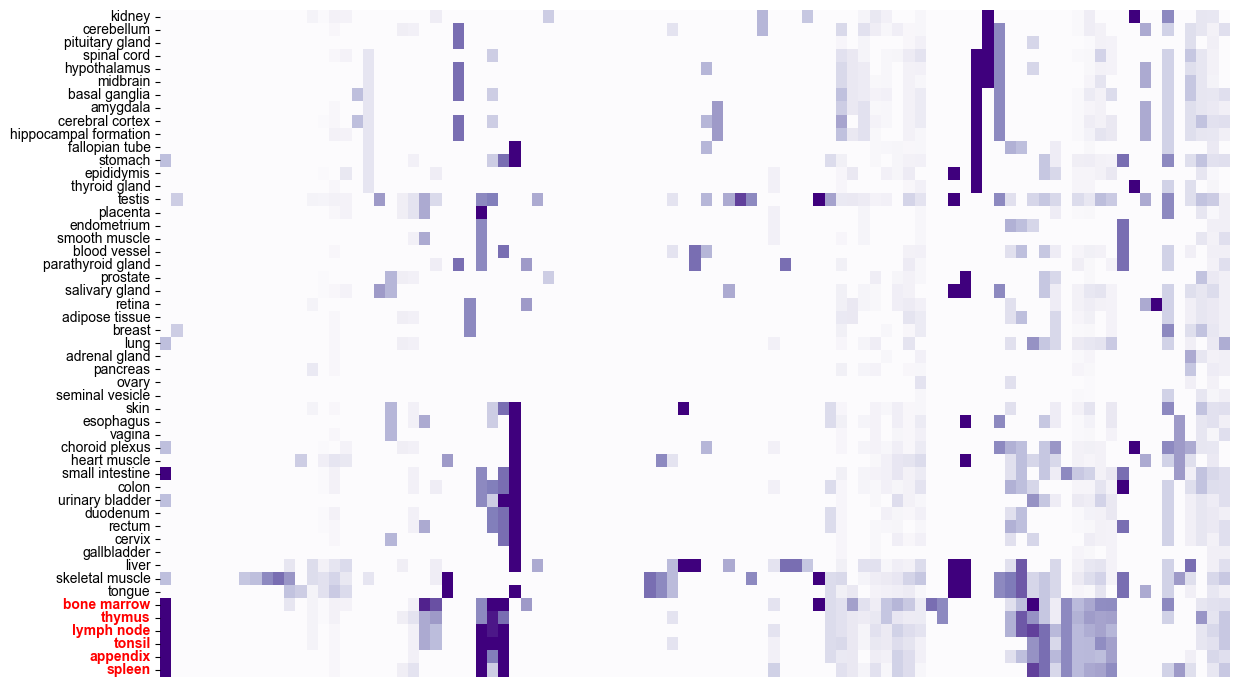

In [208]:
thres = 0.25
# Do a hierachical clustering on rows and columns
df = tissue_spec_vs_enrichment.set_index('cluster').iloc[:,2:].T.copy()
cm = sns.clustermap(df,
                    method='ward',
                    metric='euclidean',
                    row_cluster=True,
                    col_cluster=True,
                   yticklabels=True,
                    figsize=(15,6),
                   xticklabels=tissue_spec_vs_enrichment['enrichment'])
plt.close(cm.fig)

# Preserve hierachical clustering orders, separate by enrichment or not
reordered_cols = df.columns[cm.dendrogram_col.reordered_ind]
reordered_rows = df.index[cm.dendrogram_row.reordered_ind]
true_cols = [c for c in reordered_cols if tissue_spec_vs_enrichment.set_index('cluster').loc[c, 'enrichment']]
false_cols = [c for c in reordered_cols if not tissue_spec_vs_enrichment.set_index('cluster').loc[c, 'enrichment']]
new_col_order = true_cols + false_cols
reordered_rows = list(reordered_rows)
reordered_rows.remove('large_tau_fraction')

plt.figure(figsize=(12.5, 7))
ax = sns.heatmap(df.loc[reordered_rows, new_col_order], 
                 vmin=0,
                 vmax=thres, 
                 cmap='Purples',
                 xticklabels=True,
                 yticklabels=True,
                 cbar=False,)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=10)
ax.set_xticks([])
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


# Highlighting lymphoid tissues
indices_to_highlight = [45, 46, 47, 48, 49, 50] 
ytick_labels = ax.get_yticklabels()

for i, label in enumerate(ytick_labels):
    if i in indices_to_highlight:
        # Change color to red and weight to bold
        label.set_color('red')
        label.set_fontweight('bold')

ax.set_xlabel('')
        
plt.tight_layout()
plt.savefig('./results/tissue_specificity_heatmap.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_26865/4141898304.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


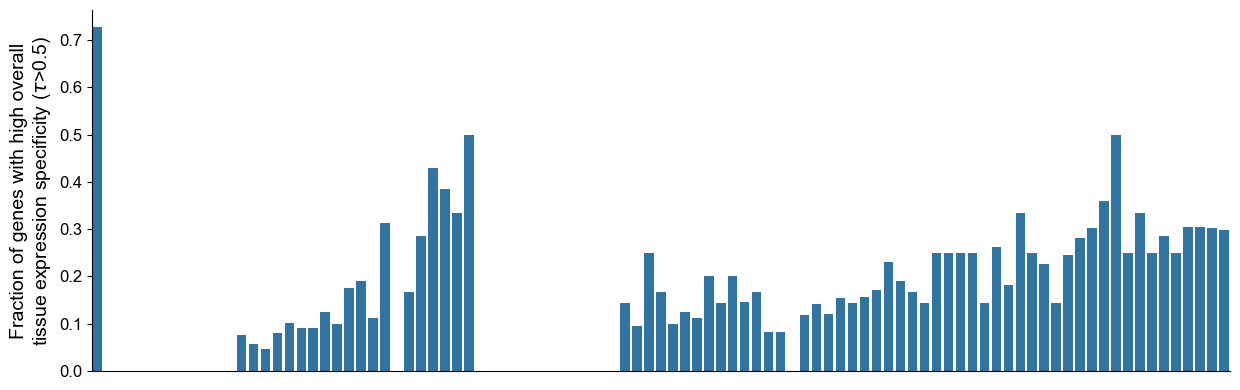

In [203]:
plt.figure(figsize=(12.5, 4))
ax = sns.barplot(tissue_spec_vs_enrichment,
                 x='cluster', 
                 y='large_tau_fraction',
                 order=new_col_order)

ax.set_xticklabels([])
ax.set_xlabel('')
ax.tick_params(axis='x', length=0)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.set_ylabel(f'Fraction of genes with high overall\n'+r'tissue expression specificity ($\tau$>'+str(TAU_THRESHOLD)+')', fontsize=14)
sns.despine()
plt.tight_layout()
plt.savefig('./results/tissue_specificity_tau_barplot.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

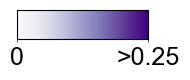

In [209]:
thres_0 = 0
thres_1 = 0.25
orientation = 'bottom'
cmap = sns.color_palette("Purples", as_cmap=True)
norm = mpl.colors.Normalize(vmin=thres_0, vmax=thres_1)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 0.9))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
cb.set_ticks([thres_0, thres_1])
cb.set_ticklabels([str(thres_0), '>'+str(thres_1)])

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(thres_0)+'_'+str(thres_1)+orientation+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [205]:
stats.mannwhitneyu(tissue_spec_vs_enrichment[tissue_spec_vs_enrichment.enrichment].large_tau_fraction, 
                   tissue_spec_vs_enrichment[~tissue_spec_vs_enrichment.enrichment].large_tau_fraction,
                  alternative='less')

MannwhitneyuResult(statistic=515.0, pvalue=0.0002480855587246573)

### Plot condition specificity for the same clusters

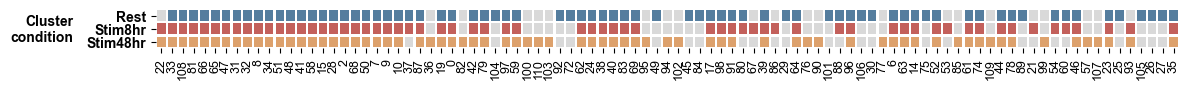

In [206]:
import matplotlib.patches as patches
# Define the conditions and their corresponding colors
conditions_ordered = ['Rest', 'Stim8hr', 'Stim48hr']
color_map = {
    'Rest': '#547d9e',
    'Stim8hr': '#c3605b',
    'Stim48hr': '#dda16c'
}
grey_color = '#d9d9d9'  # A light grey for absence

# Function to determine presence of each condition based on the string value
def get_condition_presence(specificity_str):
    presence = {}
    for cond in conditions_ordered:
        if specificity_str == 'across_condition':
             presence[cond] = True
        else:
             # Check if the condition string exists in the specificity string
             presence[cond] = cond in specificity_str
    return pd.Series(presence)

# Apply the function to create boolean columns for each condition
presence_df = cluster_df_filtered['condition_specificity'].apply(get_condition_presence)

# Sorting (Optional but highly recommended):
# Group clusters with similar patterns together for a cleaner plot.
# We sort by the presence of Rest, then 8hr, then 48hr.
presence_df_sorted = presence_df.loc[new_col_order].copy()

# ==========================================
# 3. Plotting
# ==========================================

num_clusters = len(presence_df_sorted)
num_conditions = len(conditions_ordered)

# Setup the figure. Aspect ratio is wide and short.
fig, ax = plt.subplots(figsize=(12, 1))

# Set plot limits
ax.set_xlim(0, num_clusters)
ax.set_ylim(0, num_conditions)

# Iterate through columns (clusters)
for col_idx, (cluster_id, row_data) in enumerate(presence_df_sorted.iterrows()):
    # Iterate through rows (conditions). We reverse the order so 'Rest' is on top.
    for row_idx, cond_name in enumerate(conditions_ordered[::-1]):
        
        is_present = row_data[cond_name]
        
        # Determine color based on presence
        if is_present:
            block_color = color_map[cond_name]
        else:
            block_color = grey_color
            
        # Draw the square rectangle.
        # Using patches allows for distinct blocks with gaps, unlike a standard heatmap.
        # (x, y) is bottom-left corner. We add padding (0.1) for the gap effect.
        rect = patches.Rectangle(
            (col_idx + 0.1, row_idx + 0.1), # xy coords
            0.8, 0.8,                      # width, height
            linewidth=0,
            facecolor=block_color
        )
        ax.add_patch(rect)

# Clean up the axes to match the reference image style
ax.set_xticks(np.linspace(0.5,len(new_col_order)-0.5,len(new_col_order)))
ax.set_xticklabels(new_col_order, rotation=90, ha='center', va='top', fontsize=9) # Remove X-axis ticks
ax.set_yticks([0.5, 1.5, 2.5]) # Center Y-ticks on rows
ax.set_yticklabels(conditions_ordered[::-1], fontweight='bold', fontsize=10)

# Remove plot spines (the border box)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add the main Y-axis label
ax.set_ylabel("Cluster\ncondition", fontweight='bold', fontsize=10, rotation=0, ha='right', va='center', labelpad=10)

plt.tight_layout()
plt.savefig('./results/condition_specificity_enrichment_vs_noenrichment.pdf', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()